# Cross-in-Tray Function

The Cross-in-Tray Function is a common evaluation problem for optimization algorithms. It is a 2-dimensional function with multiple local minima.  
The mathematical formulation is given as $$f(\textbf{x}) = -0.0001\left(\left|\sin(x_1)\sin(x_2)\exp\left(\left|100-\frac{\sqrt(x_1^2+x_2^2)}{\pi}\right|\right)\right|+1\right)^{0.1}$$

## Input Domain

Usually, the Cross-in-Tray Function is evaluated over the region $\textbf{x}_i = [-10,10]$ for all $i=1,2$.


## Global Minima

It's global minima is $f(\textbf{x}^*)=-2.06261$ at $\textbf{x}^* = (1.3491,-1.3491), (1.3491,1.3491), (-1.3491,1.3491)$ and $(-1.3491,-1.3491)$.

## Visualization of Function

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# Objective function
def objective(x1, x2):
    return (-0.0001*((np.abs(np.sin(x1)*np.sin(x2)*np.exp(np.abs(100-(x1**2+x2**2)**0.5/np.pi))))+1)**0.1)


Text(0.5, 0.92, 'Cross-in-Tray Surface Plot')

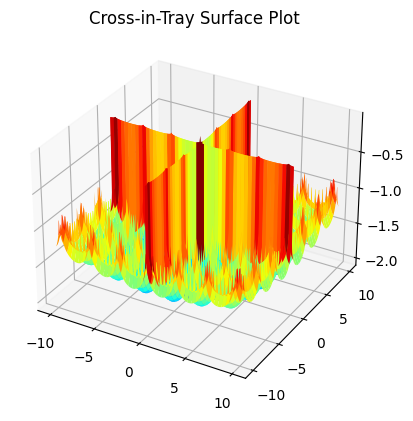

In [37]:
# Plot Cross-in-Tray Function in 3D
r_min, r_max = -10, 10
x_axis = y_axis = np.arange(r_min, r_max, 0.05)
x1, x2 = np.meshgrid(x_axis, y_axis)
f = objective(x1, x2)

figure = plt.figure()
axis = figure.add_subplot(111, projection="3d")
axis.plot_surface(x1, x2, f, cmap="jet", shade="false")

# Set the title
axis.set_title("Cross-in-Tray Surface Plot")

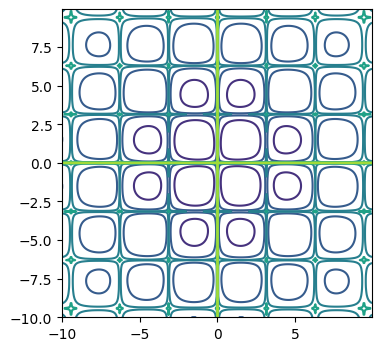

In [38]:
figure = plt.figure(figsize=(4,4))
plt.contour(x1,x2,f)

## DeepLifting Solution

In [39]:
# imports
import time
import sys
import math

# Adding PyGRANSO directories. Should be modified by user
sys.path.append("/home/seanschweiger/dl_testing/Deeplifting")

import torch
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

from deeplifting.models import DeepliftingMLP

In [40]:
# Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def cross_in_tray(x1,x2):
    return (-0.0001*((torch.abs(torch.sin(x1)*torch.sin(x2)*torch.exp(torch.abs(100-(x1**2+x2**2)**0.5/math.pi))))+1)**0.1)

def user_fn(model,inputs):
    output = model(inputs=None)
    x1, x2 = output

    # Can map x1 and x2 to [0,1] 
    # and shift interval to accomplish
    # same thing as constraints
    x1 = torch.sigmoid(x1) * (-10 - 10) + 10
    x2 = torch.sigmoid(x2) * (-10 - 10) + 10

    # Objective fn.
    f = cross_in_tray(x1, x2)

    # Inequality constraint
    ci = None

    # Equality constraint
    ce = None

    return [f, ci, ce]

In [41]:
# Build model
model = DeepliftingMLP(input_size=50, layer_sizes=(128,256,256,128), output_size=2)
model = model.to(device=device, dtype=torch.double)
nvar = getNvarTorch(model.parameters())
print(nvar)

139498


In [42]:
torch.manual_seed(1)

opts = pygransoStruct()

x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 10
opts.limited_mem_size = 100
opts.stat_l2_model = False
opts.double_precision = True
opts.viol_ineq_tol = 1e-8
opts.opt_tol = 1e-8

points = []
comb_fn = lambda model: user_fn(model, points)

# Run the main algorithm
start = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end = time.time()

print(f"Starting point for this problem = {x0}\n")
print(f"Total Wall Time: {end-start}\n")
print(soln.final.f)





╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

## PyGRANSO Solution
### Function Setup 

In [43]:
# Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input variables
var_in = {'x1': [1], 'x2':[1]}

def comb_fn(X_struct):
    x1 = X_struct.x1
    x2 = X_struct.x2

    # objective function
    f = -0.0001 * (torch.abs(torch.sin(x1)*torch.sin(x2)*torch.exp(torch.abs(100-(((x1**2+x2**2)**0.5)/np.pi))))+1)**0.1

    # inequality constraint
    ci = pygransoStruct()
    ci.c1 = -x1 - 10
    ci.c2 = x1 - 10
    ci.c3 = -x2 - 10
    ci.c4 = x2 - 10


    # equality constraint
    ce = None

    return [f,ci,ce]


### Main Algorithm

In [44]:
# opts = pygransoStruct()
# # option for switching QP solver. We only have osqp as the only qp solver in current version. Default is osqp
# # opts.QPsolver = 'osqp'

# opts.torch_device = device

# run 10 trials with different random starting points
for i in range(10):
    np.random.seed(i)
    opts = pygransoStruct()
    # initialize starting vector with random values in [-10,10]
    opts.x0 = torch.rand(size=(2,1), device=device, dtype=torch.double) * 20 - 10 
    opts.torch_device = device
    start = time.time()
    soln = pygranso(var_spec = var_in,combined_fn = comb_fn, user_opts = opts)
    end = time.time()
    print("Total Wall Time: {}s".format(end - start))
    print(soln.final.x, soln.final.f)




╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

## IPOPT Solution

In [45]:
# import statements
import numpy as np
from cyipopt import minimize_ipopt

# Objective function
def objective(x):
    return (-0.0001*((np.abs(np.sin(x[0])*np.sin(x[1])*np.exp(np.abs(100-(x[0]**2+x[1]**2)**0.5/np.pi))))+1)**0.1)

for i in range(10):
    np.random.seed(i)
    # initialize starting vector with random values in [-10,10]
    x0 = np.random.rand(2) * 20 - 10

    result = minimize_ipopt(objective, x0)
    print(f"Trial {i+1}")
    print("Optimal x* found: ", result.x)
    print("Minimum value found: ", objective(result.x))

    



Trial 1
Optimal x* found:  [1.47062223 4.41907565]
Minimum value found:  -1.8899380457855628
Trial 2
Optimal x* found:  [-1.47062219  4.41907577]
Minimum value found:  -1.889938045785566
Trial 3
Optimal x* found:  [ -1.52584934 -10.69030819]
Minimum value found:  -1.5544055622250907
Trial 4
Optimal x* found:  [1.47062218 4.41907563]
Minimum value found:  -1.889938045785562
Trial 5
Optimal x* found:  [7.55142244 1.50852134]
Minimum value found:  -1.715489416054004
Trial 6
Optimal x* found:  [-4.55012212  7.5874886 ]
Minimum value found:  -1.653885265617176
Trial 7
Optimal x* found:  [ 7.58748853 -4.55012217]
Minimum value found:  -1.6538852656171728
Trial 8
Optimal x* found:  [-7.58748853  4.55012208]
Minimum value found:  -1.653885265617175
Trial 9
Optimal x* found:  [7.63259228 7.6325923 ]
Minimum value found:  -1.5544633378037493
Trial 10
Optimal x* found:  [-10.69030813   1.52584937]
Minimum value found:  -1.5544055622250947


## Simulated Annealing Solution

In [47]:
import numpy as np
from scipy.optimize import dual_annealing

# Objective fn.
def cross_in_tray(x):
    x1 = x[0]
    x2 = x[1]
    return (-0.0001*((np.abs(np.sin(x1)*np.sin(x2)*np.exp(np.abs(100-(x1**2+x2**2)**0.5/np.pi))))+1)**0.1)

bounds = [(-10,10), (-10,10)]

# Run 10 trials
results = []
for i in range(10):
    result = dual_annealing(cross_in_tray, bounds)
    results.append(result)

print("Simulated Annealing Results")
for i,res in enumerate(results):
    print(f"Trial {i+1}")
    print(f"x: {res.x}, f(x): {res.fun}\n")

Trial 1
x: [-1.34940662 -1.34939496], f(x): -2.062611870806853

Trial 2
x: [-1.34938411  1.34940732], f(x): -2.0626118707631473

Trial 3
x: [1.3494123 1.3494056], f(x): -2.0626118708187375

Trial 4
x: [-1.3494137  1.3493843], f(x): -2.062611870755927

Trial 5
x: [-1.34939593  1.34940765], f(x): -2.0626118708090555

Trial 6
x: [ 1.34940684 -1.34940703], f(x): -2.0626118708227135

Trial 7
x: [-1.34940771 -1.34940657], f(x): -2.0626118708225953

Trial 8
x: [-1.34943841 -1.34940086], f(x): -2.0626118706974927

Trial 9
x: [-1.34936749  1.34940881], f(x): -2.062611870641616

Trial 10
x: [-1.34940624  1.34940629], f(x): -2.0626118708227095



## Differential Evolution

In [ ]:
import numpy as np
from scipy.optimize import differential_evolution

# Objective fn.
def cross_in_tray(x):
    x1 = x[0]
    x2 = x[1]
    return (-0.0001*((np.abs(np.sin(x1)*np.sin(x2)*np.exp(np.abs(100-(x1**2+x2**2)**0.5/np.pi))))+1)**0.1)

bounds = [(-10,10), (-10,10)]

# Run 10 trials
results = []
for i in range(10):
    result = differential_evolution(cross_in_tray, bounds)
    results.append(result)

print("Differential Evolution Results")
for i,res in enumerate(results):
    print(f"Trial {i+1}")
    print(f"x: {res.x}, f(x): {res.fun}\n")